In [18]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import gc
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score
import traceback
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

# ==================================================================
# DEVICE CONFIGURATION
# ==================================================================
DEVICE = torch.device("cuda:0")

# ==================================================================
# REPRODUCIBILITY SETTINGS
# ==================================================================
SEED = 42

def set_seed(seed=SEED):
    """Set all seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

# Set seeds at import time
set_seed(SEED)

## Cella 2: Configurazione Percorsi e Layer Config

In [19]:

PROJECT_ROOT = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
CACHE_DIR_NAME = "activation_cache"
HF_DEFAULT_HOME = os.environ.get("HF_HOME", "~\\.cache\\huggingface\\hub")

# Nomi dei modelli (usati come costanti in tutto il notebook)
MODEL_A = "Llama-3.1-8B-Instruct"
MODEL_B = "gemma-2-9b-it"

LAYER_CONFIG = {
    MODEL_A: 
    {
        "attn": [5,8,12],
        "mlp":[13,14,15],
        "hidden": [13,14,15]
    },    
    MODEL_B: 
    {
        "attn": [23,27,33],
        "mlp":[24,25,26],
        "hidden": [23,24,27]
    }  
}
DATASET_NAME = "belief_bank_constraints"

## Cella 3: Configurazione Encoder-Head (Teacher e Student)

In [20]:
# ==================================================================
# ENCODER-HEAD CONFIGURATION (Frozen Head Approach)
# ==================================================================
ENCODER_CONFIG = {
    "latent_dim": 256,
    "hidden_dim": 512,
    "dropout": 0.3,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "batch_size": 64,
    "max_epochs": 100,
    "early_stopping_patience": 15,
    "early_stopping_min_delta": 1e-4,
    "gradient_clip_max_norm": 1.0,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR",
    "loss_function": "BCEWithLogitsLoss",
    "use_class_weights": True
}

HEAD_CONFIG = {
    "latent_dim": 256,
    "hidden_dim": 128,
    "dropout": 0.3,
    "learning_rate": 1e-3,
    "weight_decay": 1e-2,
    "batch_size": 64,
    "max_epochs": 100,
    "early_stopping_patience": 15,
    "early_stopping_min_delta": 1e-4,
    "gradient_clip_max_norm": 1.0,
    "optimizer": "AdamW",
    "scheduler": "CosineAnnealingLR",
    "loss_function": "BCEWithLogitsLoss",
    "use_class_weights": True
}

## Cella 4: Definizione Classi Dataset e Modelli

In [21]:
# ------------------------------------------------------------------
# 1. Dataset classe per Training
# ------------------------------------------------------------------
class SimpleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()  # BCE expects float
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ------------------------------------------------------------------
# 2. ENCODER: Maps Input Dimension -> Latent Dimension
# ------------------------------------------------------------------
class Encoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dim: int = 1024, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, latent_dim),
            nn.LayerNorm(latent_dim)  # Normalize latent space for stability
        )
        
    def forward(self, x):
        return self.net(x)

# ------------------------------------------------------------------
# 3. CLASSIFICATION HEAD: Maps Latent Dimension -> Probability
# ------------------------------------------------------------------
class ClassificationHead(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int = 128, dropout: float = 0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1)  # Binary output
        )
        
    def forward(self, x):
        return self.net(x).squeeze(-1)

    def predict(self, x):
        with torch.no_grad():
            logits = self.forward(x)
            return (torch.sigmoid(logits) > 0.5).long()

## Cella 5: Funzioni Utilità per Caricamento e Seeding

In [22]:
def stats_per_json(model_name, dataset_name):
    """
    Versione originale per la vecchia struttura con hallucination_labels.json
    """
    file_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, 
                             "generations", "hallucination_labels.json")
    with open(file_path, 'r') as file:
        data = json.load(file)
    total = len(data)
    hallucinations = sum(1 for item in data if item['is_hallucination'])
    hallucinated_items = [item['instance_id'] for item in data if item['is_hallucination']]
    return {
        'total': total,
        'hallucinations': hallucinations,
        'hallucinated_items': hallucinated_items,
        'model_name': model_name
    }

def stats_from_new_structure(model_name, dataset_name):
    """
    Nuova funzione per la struttura con cartelle hallucinated/ e not_hallucinated/
    """
    base_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, "activation_attn")
    hallucinated_path = os.path.join(base_path, "hallucinated")
    not_hallucinated_path = os.path.join(base_path, "not_hallucinated")
    
    hall_ids_path = os.path.join(hallucinated_path, "layer0_instance_ids.json")
    not_hall_ids_path = os.path.join(not_hallucinated_path, "layer0_instance_ids.json")
    
    with open(hall_ids_path, 'r') as f:
        hallucinated_ids = json.load(f)
    with open(not_hall_ids_path, 'r') as f:
        not_hallucinated_ids = json.load(f)
    
    total = len(hallucinated_ids) + len(not_hallucinated_ids)
    hallucinations = len(hallucinated_ids)
    
    return {
        'total': total,
        'hallucinations': hallucinations,
        'not_hallucinations': len(not_hallucinated_ids),
        'hallucinated_ids': hallucinated_ids,
        'not_hallucinated_ids': not_hallucinated_ids,
        'hallucinated_items': hallucinated_ids,  # Alias per compatibilità
        'model_name': model_name
    }

def detect_structure_type(model_name, dataset_name):
    """
    Rileva automaticamente se la struttura è vecchia o nuova.
    """
    base_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name, "activation_attn")
    hallucinated_path = os.path.join(base_path, "hallucinated")
    if os.path.isdir(hallucinated_path):
        return 'new'
    return 'old'

def get_stats(model_name, dataset_name):
    """
    Funzione wrapper che rileva automaticamente la struttura e chiama la funzione appropriata.
    """
    structure = detect_structure_type(model_name, dataset_name)
    if structure == 'new':
        return stats_from_new_structure(model_name, dataset_name)
    else:
        return stats_per_json(model_name, dataset_name)




def get_balanced_indices(y, seed=SEED):
    """
    Calcola gli indici per bilanciare il dataset tramite undersampling.
    Questa funzione è DETERMINISTICA dato lo stesso seed e le stesse label.
    
    Args:
        y: numpy array delle label
        seed: seed per la riproducibilità
    
    Returns:
        balanced_indices: numpy array degli indici selezionati (ordinati)
    """
    rng = np.random.RandomState(seed)
    
    # Trova le classi e i loro conteggi
    unique_classes, counts = np.unique(y, return_counts=True)
    min_count = counts.min()
    
    selected_indices = []
    
    for cls in unique_classes:
        cls_indices = np.where(y == cls)[0]
        
        if len(cls_indices) > min_count:
            # Undersampling: seleziona casualmente min_count campioni
            sampled = rng.choice(cls_indices, size=min_count, replace=False)
            selected_indices.extend(sampled)
        else:
            # Classe già al minimo, prendi tutti
            selected_indices.extend(cls_indices)
    
    # Ordina gli indici per mantenere consistenza
    return np.sort(np.array(selected_indices))


def get_undersampled_indices_per_model(model_stats, seed=SEED):
    """
    Applica undersampling al dataset di un singolo modello.
    Usato per addestrare su dati specifici del modello.
    
    Args:
        model_stats: dizionario con statistiche del modello (da get_stats)
        seed: seed per riproducibilità
    
    Returns:
        balanced_idx: array di indici bilanciati
        balanced_labels: array di label corrispondenti
    """
    total = model_stats['total']
    hall_set = set(model_stats['hallucinated_items'])
    
    y = np.array([1 if i in hall_set else 0 for i in range(total)])
    balanced_idx = get_balanced_indices(y, seed)
    balanced_labels = y[balanced_idx]
    
    return balanced_idx, balanced_labels


def get_generator(seed=SEED):
    """Create reproducible generator for DataLoader"""
    g = torch.Generator()
    g.manual_seed(seed)
    return g


def load_and_split_layers(model_name, dataset_name, layer_indices, type_layer,
                          balanced_indices, balanced_labels, train_indices, test_indices):
    """
    Load activation layers with balanced indices pre-calculated.
    Supporta sia la vecchia struttura (file direttamente in activation_X/)
    sia la nuova struttura (file in hallucinated/ e not_hallucinated/).
    
    Args:
        balanced_indices: global indices for concordant and balanced samples
        balanced_labels: corresponding labels (shared between models)
        train_indices: LOCAL indices (0..len(balanced_indices)-1) for training
        test_indices: LOCAL indices (0..len(balanced_indices)-1) for test
    """
    print(f" Loading {model_name} [{type_layer}]: layers {layer_indices}...")

    # Rileva la struttura
    structure_type = detect_structure_type(model_name, dataset_name)
    print(f"  Struttura rilevata: {structure_type}")

    all_features = []
    for layer_idx in layer_indices:
        base_path = os.path.join(PROJECT_ROOT, CACHE_DIR_NAME, model_name, dataset_name,
                                 "activation_" + type_layer)
        
        if structure_type == 'new':
            # Nuova struttura: carica da hallucinated/ e not_hallucinated/ separatamente
            hall_path = os.path.join(base_path, "hallucinated", f"layer{layer_idx}_activations.pt")
            not_hall_path = os.path.join(base_path, "not_hallucinated", f"layer{layer_idx}_activations.pt")
            hall_ids_path = os.path.join(base_path, "hallucinated", f"layer{layer_idx}_instance_ids.json")
            not_hall_ids_path = os.path.join(base_path, "not_hallucinated", f"layer{layer_idx}_instance_ids.json")
            
            if not os.path.exists(hall_path) or not os.path.exists(not_hall_path):
                print(f" Warning: Layer {layer_idx} non trovato. Salto.")
                continue
            
            print(f"  Loading layer {layer_idx} (new structure)...", end=" ")
            
            # Carica le attivazioni
            acts_hall = torch.load(hall_path, map_location='cpu')
            acts_not_hall = torch.load(not_hall_path, map_location='cpu')
            
            # Carica gli instance_ids per sapere l'ordine
            with open(hall_ids_path, 'r') as f:
                hall_ids = json.load(f)
            with open(not_hall_ids_path, 'r') as f:
                not_hall_ids = json.load(f)
            
            # Convert to numpy
            if isinstance(acts_hall, torch.Tensor):
                X_hall = acts_hall.float().numpy()
            else:
                X_hall = acts_hall.astype(np.float32)
                
            if isinstance(acts_not_hall, torch.Tensor):
                X_not_hall = acts_not_hall.float().numpy()
            else:
                X_not_hall = acts_not_hall.astype(np.float32)
            
            # Flatten if needed
            if X_hall.ndim > 2:
                X_hall = X_hall.reshape(X_hall.shape[0], -1)
            if X_not_hall.ndim > 2:
                X_not_hall = X_not_hall.reshape(X_not_hall.shape[0], -1)
            
            # Ricostruisci l'array completo nell'ordine originale degli indici
            total_samples = len(hall_ids) + len(not_hall_ids)
            feature_dim = X_hall.shape[1]
            X_layer = np.zeros((total_samples, feature_dim), dtype=np.float32)
            
            # Mappa: instance_id -> posizione nel file
            for i, inst_id in enumerate(hall_ids):
                X_layer[inst_id] = X_hall[i]
            for i, inst_id in enumerate(not_hall_ids):
                X_layer[inst_id] = X_not_hall[i]
            
            del acts_hall, acts_not_hall, X_hall, X_not_hall
            
        else:
            # Vecchia struttura: file direttamente nella cartella
            file_path = os.path.join(base_path, f"layer{layer_idx}_activations.pt")
            if not os.path.exists(file_path):
                print(f" Warning: Layer {layer_idx} non trovato. Salto.")
                continue

            print(f"  Loading layer {layer_idx} (old structure)...", end=" ")
            acts = torch.load(file_path, map_location='cpu')

            X_layer = acts.float().numpy() if isinstance(acts, torch.Tensor) else acts.astype(np.float32)
            if X_layer.ndim > 2:
                X_layer = X_layer.reshape(X_layer.shape[0], -1)
            
            del acts
            
        # Select ONLY balanced samples
        X_layer = X_layer[balanced_indices]
        all_features.append(X_layer)
        print(f"done ({X_layer.shape})")
        
        gc.collect()

    if not all_features:
        raise ValueError(f"No layers found for {model_name}")

    X_balanced = np.concatenate(all_features, axis=1)
    
    X_train = X_balanced[train_indices]
    X_test = X_balanced[test_indices]
    y_train = balanced_labels[train_indices]
    y_test = balanced_labels[test_indices]
    
    print(f" Completed! Train: {X_train.shape}, Test: {X_test.shape}")

    return X_train, X_test, y_train, y_test

## Cella 6: Funzione Training Teacher (Encoder + Head Jointly)

In [23]:
def train_teacher_pipeline(X_train, y_train, X_val, y_val, input_dim, device, 
                          model_name, encoder_config=ENCODER_CONFIG, head_config=HEAD_CONFIG):
    """Train encoder + head jointly for teacher model"""
    print(f"   [Teacher] Training full pipeline for {model_name}...")
    
    set_seed(SEED)
    
    # Initialize modules
    encoder = Encoder(input_dim, encoder_config['latent_dim'], 
                     encoder_config['hidden_dim'], encoder_config['dropout']).to(device)
    head = ClassificationHead(encoder_config['latent_dim'], 
                             head_config['hidden_dim'], head_config['dropout']).to(device)
    
    # Combine parameters for optimizer
    params = list(encoder.parameters()) + list(head.parameters())
    optimizer = optim.AdamW(params, lr=encoder_config['learning_rate'], 
                           weight_decay=encoder_config['weight_decay'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=encoder_config['max_epochs'])
    
    # Class weights for imbalance
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    if n_pos > 0:
        pos_weight = torch.tensor([n_neg / n_pos]).to(device)
    else:
        pos_weight = torch.tensor([1.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    train_loader = DataLoader(SimpleDataset(X_train, y_train), 
                             batch_size=encoder_config['batch_size'], 
                             shuffle=True, generator=get_generator(SEED))
    val_loader = DataLoader(SimpleDataset(X_val, y_val), 
                           batch_size=encoder_config['batch_size'], shuffle=False)
    
    best_acc = 0.0
    patience_counter = 0
    best_states = None
    epochs_trained = 0
    
    for epoch in range(encoder_config['max_epochs']):
        encoder.train()
        head.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            
            latents = encoder(X_batch)
            logits = head(latents)
            
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(head.parameters()),
                                          max_norm=encoder_config['gradient_clip_max_norm'])
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        encoder.eval()
        head.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                latents = encoder(X_batch)
                preds = head.predict(latents)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        scheduler.step()
        
        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
            best_states = {
                'encoder': encoder.state_dict().copy(),
                'head': head.state_dict().copy()
            }
            epochs_trained = epoch + 1
        else:
            patience_counter += 1
            if patience_counter >= encoder_config['early_stopping_patience']:
                print(f"     Early stopping at epoch {epoch+1}. Best Acc: {best_acc:.4f}")
                break
    
    if epochs_trained == 0:
        epochs_trained = encoder_config['max_epochs']
    
    encoder.load_state_dict(best_states['encoder'])
    head.load_state_dict(best_states['head'])
    
    return encoder, head, best_acc, epochs_trained

## Cella 7: Funzione Training Student (Adapter con Head Frozen)

In [24]:
def train_student_adapter(X_train, y_train, X_val, y_val, input_dim, frozen_head, device, 
                         student_name, encoder_config=ENCODER_CONFIG):
    """Train new encoder with frozen head from teacher"""
    print(f"   [Student] Training Adapter Encoder for {student_name} (Head Frozen)...")
    
    # Freeze the Head
    frozen_head.eval()
    for param in frozen_head.parameters():
        param.requires_grad = False
    
    set_seed(SEED)
    
    # New Encoder for Student
    encoder = Encoder(input_dim, encoder_config['latent_dim'], 
                     encoder_config['hidden_dim'], encoder_config['dropout']).to(device)
    
    # Optimize ONLY the encoder
    optimizer = optim.AdamW(encoder.parameters(), lr=encoder_config['learning_rate'], 
                           weight_decay=encoder_config['weight_decay'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=encoder_config['max_epochs'])
    
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    if n_pos > 0:
        pos_weight = torch.tensor([n_neg / n_pos]).to(device)
    else:
        pos_weight = torch.tensor([1.0]).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    train_loader = DataLoader(SimpleDataset(X_train, y_train), 
                             batch_size=encoder_config['batch_size'], 
                             shuffle=True, generator=get_generator(SEED))
    val_loader = DataLoader(SimpleDataset(X_val, y_val), 
                           batch_size=encoder_config['batch_size'], shuffle=False)
    
    best_acc = 0.0
    patience_counter = 0
    best_state = None
    epochs_trained = 0
    
    for epoch in range(encoder_config['max_epochs']):
        encoder.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            
            # Forward pass: Student Input -> Student Encoder -> Frozen Head -> Loss
            latents = encoder(X_batch)
            logits = frozen_head(latents)  # Head is fixed
            
            loss = criterion(logits, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(),
                                          max_norm=encoder_config['gradient_clip_max_norm'])
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        encoder.eval()
        all_preds, all_labels = [], []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                latents = encoder(X_batch)
                preds = frozen_head.predict(latents)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(y_batch.numpy())
        
        acc = accuracy_score(all_labels, all_preds)
        scheduler.step()
        
        if acc > best_acc:
            best_acc = acc
            patience_counter = 0
            best_state = encoder.state_dict().copy()
            epochs_trained = epoch + 1
        else:
            patience_counter += 1
            if patience_counter >= encoder_config['early_stopping_patience']:
                print(f"     Early stopping at epoch {epoch+1}. Best Acc: {best_acc:.4f}")
                break
    
    if epochs_trained == 0:
        epochs_trained = encoder_config['max_epochs']
    
    # Load best state
    if best_state is not None:
        encoder.load_state_dict(best_state)
    
    return encoder, best_acc, epochs_trained

## Cella 8: Funzione Salvataggio Confusion Matrix

In [20]:
def plot_confusion_matrix(y_true, y_pred, title, filename):
    """Plot and save confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    os.makedirs("confusion_matrices_frozen_head", exist_ok=True)
    plt.savefig(os.path.join("confusion_matrices_frozen_head", filename))
    plt.close()

## Cella 9: Main Execution - Setup Iniziale

In [21]:
# Load statistics
model_a_stats = get_stats(MODEL_A, DATASET_NAME)
model_b_stats = get_stats(MODEL_B, DATASET_NAME)

print(f"\n{'='*60}")
print("PREPARAZIONE DATASET INDIPENDENTI E BILANCIATI PER OGNI MODELLO")
print(f"{'='*60}")
print(f"{MODEL_A} totali: {model_a_stats['total']}, hallucinated: {model_a_stats['hallucinations']}")
print(f"{MODEL_B} totali: {model_b_stats['total']}, hallucinated: {model_b_stats['hallucinations']}")
print()

# Undersampling SEPARATO per ogni modello (NON concordante)
# Questo permette a ogni modello di usare il suo dataset bilanciato indipendentemente
print("Applying separate undersampling for each model...")
model_a_balanced_idx, model_a_balanced_labels = get_undersampled_indices_per_model(model_a_stats, SEED)
model_b_balanced_idx, model_b_balanced_labels = get_undersampled_indices_per_model(model_b_stats, SEED)

print(f"  {MODEL_A}: {len(model_a_balanced_idx)} bilanciati ({np.sum(model_a_balanced_labels==1)} hall, {np.sum(model_a_balanced_labels==0)} non-hall)")
print(f"  {MODEL_B}: {len(model_b_balanced_idx)} bilanciati ({np.sum(model_b_balanced_labels==1)} hall, {np.sum(model_b_balanced_labels==0)} non-hall)")

# Prepare indices per ogni modello - LOCAL (0..len(balanced_idx)-1)
print("\nPreparing train/test split for each model...")

# Split per Model A
rng_a = np.random.RandomState(SEED)
shuffled_a = rng_a.permutation(len(model_a_balanced_idx))
split_a = int(0.7 * len(model_a_balanced_idx))
train_indices_a = shuffled_a[:split_a]
test_indices_a = shuffled_a[split_a:]

# Split per Model B
rng_b = np.random.RandomState(SEED + 1)
shuffled_b = rng_b.permutation(len(model_b_balanced_idx))
split_b = int(0.7 * len(model_b_balanced_idx))
train_indices_b = shuffled_b[:split_b]
test_indices_b = shuffled_b[split_b:]

print(f"\n{MODEL_A}:")
print(f"  Train: {len(train_indices_a)}, Test: {len(test_indices_a)}")
print(f"  Train labels - Hall: {np.sum(model_a_balanced_labels[train_indices_a]==1)}, Non-Hall: {np.sum(model_a_balanced_labels[train_indices_a]==0)}")
print(f"  Test labels  - Hall: {np.sum(model_a_balanced_labels[test_indices_a]==1)}, Non-Hall: {np.sum(model_a_balanced_labels[test_indices_a]==0)}")

print(f"\n{MODEL_B}:")
print(f"  Train: {len(train_indices_b)}, Test: {len(test_indices_b)}")
print(f"  Train labels - Hall: {np.sum(model_b_balanced_labels[train_indices_b]==1)}, Non-Hall: {np.sum(model_b_balanced_labels[train_indices_b]==0)}")
print(f"  Test labels  - Hall: {np.sum(model_b_balanced_labels[test_indices_b]==1)}, Non-Hall: {np.sum(model_b_balanced_labels[test_indices_b]==0)}")

device = DEVICE
print(f"\nUsing device: {device}")

results_log = []

# Define scenarios
scenarios = [
    {"teacher": MODEL_A, "student": MODEL_B},
    {"teacher": MODEL_B, "student": MODEL_A}
]

print(f"\nConfiguration:")
print(f"  LATENT_DIM: {ENCODER_CONFIG['latent_dim']}")
print(f"  HIDDEN_DIM: {ENCODER_CONFIG['hidden_dim']}")
print(f"  MAX_EPOCHS: {ENCODER_CONFIG['max_epochs']}")
print(f"  BATCH_SIZE: {ENCODER_CONFIG['batch_size']}")


PREPARAZIONE DATASET INDIPENDENTI E BILANCIATI PER OGNI MODELLO
Qwen2.5-7B totali: 27416, hallucinated: 3565
Falcon3-7B-Base totali: 27416, hallucinated: 7531

Applying separate undersampling for each model...
  Qwen2.5-7B: 7130 bilanciati (3565 hall, 3565 non-hall)
  Falcon3-7B-Base: 15062 bilanciati (7531 hall, 7531 non-hall)

Preparing train/test split for each model...

Qwen2.5-7B:
  Train: 4991, Test: 2139
  Train labels - Hall: 2467, Non-Hall: 2524
  Test labels  - Hall: 1098, Non-Hall: 1041

Falcon3-7B-Base:
  Train: 10543, Test: 4519
  Train labels - Hall: 5320, Non-Hall: 5223
  Test labels  - Hall: 2211, Non-Hall: 2308

Using device: cuda:0

Configuration:
  LATENT_DIM: 256
  HIDDEN_DIM: 512
  MAX_EPOCHS: 100
  BATCH_SIZE: 64


## Cella 10: Main Execution - Loop per Layer Types

In [22]:
for layer_type in ['attn', 'mlp', 'hidden']:
    print(f"\n{'='*60}")
    print(f"PROCESSING LAYER TYPE: {layer_type.upper()}")
    print(f"{'='*60}")
    
    # Load data for MODEL_A (con suo dataset bilanciato)
    print(f"Loading data for {MODEL_A} (independent balanced dataset)...")
    X_model_a_tr, X_model_a_te, y_model_a_tr, y_model_a_te = load_and_split_layers(
        MODEL_A, DATASET_NAME, LAYER_CONFIG[MODEL_A][layer_type], 
        layer_type, model_a_balanced_idx, model_a_balanced_labels, train_indices_a, test_indices_a)

    # Load data for MODEL_B (con suo dataset bilanciato)
    print(f"Loading data for {MODEL_B} (independent balanced dataset)...")
    X_model_b_tr, X_model_b_te, y_model_b_tr, y_model_b_te = load_and_split_layers(
        MODEL_B, DATASET_NAME, LAYER_CONFIG[MODEL_B][layer_type], 
        layer_type, model_b_balanced_idx, model_b_balanced_labels, train_indices_b, test_indices_b)

    # Scaling (Independent for each model)
    s_model_a = StandardScaler()
    X_model_a_tr = s_model_a.fit_transform(X_model_a_tr).astype(np.float32)
    X_model_a_te = s_model_a.transform(X_model_a_te).astype(np.float32)

    s_model_b = StandardScaler()
    X_model_b_tr = s_model_b.fit_transform(X_model_b_tr).astype(np.float32)
    X_model_b_te = s_model_b.transform(X_model_b_te).astype(np.float32)

    # Pack data - labels are the SAME for both models now!
    data_map = {
        MODEL_A: {"X_tr": X_model_a_tr, "y_tr": y_model_a_tr, "X_te": X_model_a_te, "y_te": y_model_a_te},
        MODEL_B: {"X_tr": X_model_b_tr, "y_tr": y_model_b_tr, "X_te": X_model_b_te, "y_te": y_model_b_te}
    }

    # Run Both Scenarios
    for sc in scenarios:
        t_name = sc['teacher']
        s_name = sc['student']
        print(f"\n--- SCENARIO: Teacher={t_name} -> Student={s_name} ---")
        
        teacher_data = data_map[t_name]
        student_data = data_map[s_name]
        
        # --- PHASE 0: Create SEPARATE train/val splits for Teacher and Student ---
        # Teacher split
        n_tr_teacher = len(teacher_data["X_tr"])
        idx_teacher = np.arange(n_tr_teacher)
        np.random.seed(SEED)  
        np.random.shuffle(idx_teacher)
        v_size_teacher = int(0.15 * n_tr_teacher)
        tr_idx_teacher, val_idx_teacher = idx_teacher[v_size_teacher:], idx_teacher[:v_size_teacher]
        
        # Student split
        n_tr_student = len(student_data["X_tr"])
        idx_student = np.arange(n_tr_student)
        np.random.seed(SEED + 100)  # Different seed for student
        np.random.shuffle(idx_student)
        v_size_student = int(0.15 * n_tr_student)
        tr_idx_student, val_idx_student = idx_student[v_size_student:], idx_student[:v_size_student]
        
        # --- PHASE 1: Train Teacher ---
        enc_teacher, head_shared, best_acc_t, teacher_epochs = train_teacher_pipeline(
            teacher_data["X_tr"][tr_idx_teacher], teacher_data["y_tr"][tr_idx_teacher],
            teacher_data["X_tr"][val_idx_teacher], teacher_data["y_tr"][val_idx_teacher],
            input_dim=teacher_data["X_tr"].shape[1],
            device=device, model_name=t_name,
            encoder_config=ENCODER_CONFIG, head_config=HEAD_CONFIG
        )
        
        # Evaluate Teacher on Test
        enc_teacher.eval()
        head_shared.eval()
        with torch.no_grad():
            z_t = enc_teacher(torch.from_numpy(teacher_data["X_te"]).float().to(device))
            preds_t = head_shared.predict(z_t).cpu().numpy()
            # Get probabilities for AUROC
            logits_t = head_shared(z_t)
            probs_t = torch.sigmoid(logits_t).cpu().numpy()
        
        t_f1 = f1_score(teacher_data["y_te"], preds_t)
        t_acc = accuracy_score(teacher_data["y_te"], preds_t)
        t_prec = precision_score(teacher_data["y_te"], preds_t)
        t_rec = recall_score(teacher_data["y_te"], preds_t)
        t_cm = confusion_matrix(teacher_data["y_te"], preds_t)
        t_auroc = roc_auc_score(teacher_data["y_te"], probs_t)
        print(f"   [Result] Teacher ({t_name}) Test F1: {t_f1:.4f} | Acc: {t_acc:.4f} | AUROC: {t_auroc:.4f}")
        plot_confusion_matrix(teacher_data["y_te"], preds_t, 
                             f"Teacher {t_name} ({layer_type})", 
                             f"cm_{layer_type}_teacher_{t_name}.png")

        # --- PHASE 2: Train Student with Frozen Head ---
        enc_student, best_acc_s, student_epochs = train_student_adapter(
            student_data["X_tr"][tr_idx_student], student_data["y_tr"][tr_idx_student],
            student_data["X_tr"][val_idx_student], student_data["y_tr"][val_idx_student],
            input_dim=student_data["X_tr"].shape[1],
            frozen_head=head_shared,
            device=device, student_name=s_name,
            encoder_config=ENCODER_CONFIG
        )
        
        # Evaluate Student on Test
        enc_student.eval()
        with torch.no_grad():
            z_s = enc_student(torch.from_numpy(student_data["X_te"]).float().to(device))
            preds_s = head_shared.predict(z_s).cpu().numpy()
            # Get probabilities for AUROC
            logits_s = head_shared(z_s)
            probs_s = torch.sigmoid(logits_s).cpu().numpy()
        
        s_f1 = f1_score(student_data["y_te"], preds_s)
        s_acc = accuracy_score(student_data["y_te"], preds_s)
        s_prec = precision_score(student_data["y_te"], preds_s)
        s_rec = recall_score(student_data["y_te"], preds_s)
        s_cm = confusion_matrix(student_data["y_te"], preds_s)
        s_auroc = roc_auc_score(student_data["y_te"], probs_s)
        
        print(f"   [Result] Student ({s_name}) Adapter Test F1: {s_f1:.4f} | Acc: {s_acc:.4f} | AUROC: {s_auroc:.4f}")
        plot_confusion_matrix(student_data["y_te"], preds_s, 
                             f"Student {s_name} Adapter ({layer_type})", 
                             f"cm_{layer_type}_{s_name}_adapter.png")
        
        # --- PHASE 3: Save Models ---
        print("   Saving models...")
        model_save_dir = os.path.join("models_frozen_head", layer_type)
        os.makedirs(model_save_dir, exist_ok=True)
        
        # Save Teacher Encoder
        teacher_encoder_filename = os.path.join(model_save_dir, f"frozen_head_encoder_{t_name}.pt")
        torch.save({
            'model_state_dict': enc_teacher.state_dict(),
            'encoder_config': ENCODER_CONFIG,
            'input_dim': int(teacher_data["X_tr"].shape[1]),
            'latent_dim': ENCODER_CONFIG['latent_dim'],
            'best_val_acc': best_acc_t,
            'epochs_trained': teacher_epochs,
            'model_name': t_name,
            'layer_type': layer_type,
            'scenario': f"{t_name}_teacher"
        }, teacher_encoder_filename)
        print(f"     ✓ Teacher Encoder saved: {teacher_encoder_filename}")
        
        # Save Shared Head
        head_filename = os.path.join(model_save_dir, f"frozen_head_shared_head_{t_name}.pt")
        torch.save({
            'model_state_dict': head_shared.state_dict(),
            'head_config': HEAD_CONFIG,
            'latent_dim': ENCODER_CONFIG['latent_dim'],
            'best_val_acc': best_acc_t,
            'epochs_trained': teacher_epochs,
            'teacher_model': t_name,
            'layer_type': layer_type,
            'scenario': f"{t_name}_head"
        }, head_filename)
        print(f"     ✓ Shared Head saved: {head_filename}")
        
        # Save Student Encoder
        student_encoder_filename = os.path.join(model_save_dir, f"frozen_head_encoder_{s_name}_adapter.pt")
        torch.save({
            'model_state_dict': enc_student.state_dict(),
            'encoder_config': ENCODER_CONFIG,
            'input_dim': int(student_data["X_tr"].shape[1]),
            'latent_dim': ENCODER_CONFIG['latent_dim'],
            'best_val_acc': best_acc_s,
            'epochs_trained': student_epochs,
            'model_name': s_name,
            'layer_type': layer_type,
            'scenario': f"{s_name}_student_adapter"
        }, student_encoder_filename)
        print(f"     ✓ Student Encoder saved: {student_encoder_filename}")
        
        # Log results with model paths
        results_log.append({
            "layer": layer_type,
            "teacher": t_name,
            "student": s_name,
            "teacher_auroc": t_auroc,
            "teacher_cm": t_cm.tolist(),
            "teacher_acc":t_acc,
            "teacher_prec":t_prec,
            "teacher_rec":t_rec,
            "teacher_f1":t_f1,
            "teacher_auroc":t_auroc,
            "teacher_epochs": teacher_epochs,
            "student_acc": s_acc,
            "student_f1": s_f1,
            "student_prec": s_prec,
            "student_rec": s_rec,
            "student_auroc": s_auroc,
            "student_cm": s_cm.tolist(),
            "student_epochs": student_epochs,
            "gap_acc": t_acc - s_acc,
            "teacher_encoder_path": teacher_encoder_filename,
            "teacher_input_dim": int(teacher_data["X_tr"].shape[1]),
            "shared_head_path": head_filename,
            "student_encoder_path": student_encoder_filename,
            "student_input_dim": int(student_data["X_tr"].shape[1]),
            "encoder_config": ENCODER_CONFIG,
            "head_config": HEAD_CONFIG
        })
        torch.cuda.empty_cache()
        gc.collect()




PROCESSING LAYER TYPE: ATTN
Loading data for Qwen2.5-7B (independent balanced dataset)...
 Loading Qwen2.5-7B [attn]: layers [14, 15, 17]...
  Struttura rilevata: old
  Loading layer 14 (old structure)... done ((7130, 3584))
  Loading layer 15 (old structure)... done ((7130, 3584))
  Loading layer 17 (old structure)... done ((7130, 3584))
 Completed! Train: (4991, 10752), Test: (2139, 10752)
Loading data for Falcon3-7B-Base (independent balanced dataset)...
 Loading Falcon3-7B-Base [attn]: layers [18, 19, 26]...
  Struttura rilevata: old
  Loading layer 18 (old structure)... done ((15062, 3072))
  Loading layer 19 (old structure)... done ((15062, 3072))
  Loading layer 26 (old structure)... done ((15062, 3072))
 Completed! Train: (10543, 9216), Test: (4519, 9216)

--- SCENARIO: Teacher=Qwen2.5-7B -> Student=Falcon3-7B-Base ---
   [Teacher] Training full pipeline for Qwen2.5-7B...
     Early stopping at epoch 18. Best Acc: 0.9933
   [Result] Teacher (Qwen2.5-7B) Test F1: 0.9896 | Acc: 

## Cella 11: Salvataggio Risultati e Summary

In [23]:
# Save final metrics with detailed information
os.makedirs("results_metrics", exist_ok=True)
metrics_file = "results_metrics/approach3_frozen_head_results.json"

detailed_results = []

for r in results_log:
    # Determine which model is teacher to get correct sample counts
    if r['teacher'] == MODEL_A:
        n_train_teacher = len(train_indices_a)
        n_test_teacher = len(test_indices_a)
        n_train_student = len(train_indices_b)
        n_test_student = len(test_indices_b)
    else:
        n_train_teacher = len(train_indices_b)
        n_test_teacher = len(test_indices_b)
        n_train_student = len(train_indices_a)
        n_test_student = len(test_indices_a)
    
    result_entry = {
        "layer_type": r['layer'],
        "teacher_model": r['teacher'],
        "student_model": r['student'],
        "data_info": {
            "teacher_train_samples": int(n_train_teacher),
            "teacher_test_samples": int(n_test_teacher),
            "student_train_samples": int(n_train_student),
            "student_test_samples": int(n_test_student),
            "independent_undersampling_per_model": True
        },
        
        # ==================== ENCODER CONFIG ====================
        "encoder_config": {
            "architecture": {
                "latent_dim": r['encoder_config']['latent_dim'],
                "hidden_dim": r['encoder_config']['hidden_dim'],
                "dropout": r['encoder_config']['dropout']
            },
            "training_hyperparameters": {
                "learning_rate": r['encoder_config']['learning_rate'],
                "weight_decay": r['encoder_config']['weight_decay'],
                "batch_size": r['encoder_config']['batch_size'],
                "max_epochs": r['encoder_config']['max_epochs'],
                "early_stopping_patience": r['encoder_config']['early_stopping_patience'],
                "early_stopping_min_delta": r['encoder_config']['early_stopping_min_delta'],
                "gradient_clip_max_norm": r['encoder_config']['gradient_clip_max_norm'],
                "optimizer": r['encoder_config']['optimizer'],
                "scheduler": r['encoder_config']['scheduler'],
                "loss_function": r['encoder_config']['loss_function'],
                "use_class_weights": r['encoder_config']['use_class_weights']
            }
        },
        
        # ==================== HEAD CONFIG ====================
        "head_config": {
            "architecture": {
                "latent_dim": r['head_config']['latent_dim'],
                "hidden_dim": r['head_config']['hidden_dim'],
                "dropout": r['head_config']['dropout']
            },
            "training_hyperparameters": {
                "learning_rate": r['head_config']['learning_rate'],
                "weight_decay": r['head_config']['weight_decay'],
                "batch_size": r['head_config']['batch_size'],
                "max_epochs": r['head_config']['max_epochs'],
                "early_stopping_patience": r['head_config']['early_stopping_patience'],
                "early_stopping_min_delta": r['head_config']['early_stopping_min_delta'],
                "gradient_clip_max_norm": r['head_config']['gradient_clip_max_norm'],
                "optimizer": r['head_config']['optimizer'],
                "scheduler": r['head_config']['scheduler'],
                "loss_function": r['head_config']['loss_function'],
                "use_class_weights": r['head_config']['use_class_weights']
            }
        },
        
        # ==================== TRAINING RESULTS ====================
        "training_results": {
            "teacher_encoder": {
                "input_dim": r['teacher_input_dim'],
                "epochs_trained": r['teacher_epochs'],
                "model_saved_path": r['teacher_encoder_path']
            },
            "shared_head": {
                "epochs_trained": r['teacher_epochs'],
                "model_saved_path": r['shared_head_path']
            },
            "student_encoder": {
                "input_dim": r['student_input_dim'],
                "epochs_trained": r['student_epochs'],
                "model_saved_path": r['student_encoder_path']
            }
        },
        
        # ==================== PERFORMANCE METRICS ====================
        "metrics": {
            "teacher": {
                "accuracy": round(r['teacher_acc'], 4),
                "precision": round(r['teacher_prec'], 4),
                "recall": round(r['teacher_rec'], 4),
                "f1_score": round(r['teacher_f1'], 4),
                "auroc": round(r['teacher_auroc'], 4),
                "confusion_matrix": {
                    "TN": int(r['teacher_cm'][0][0]),
                    "FP": int(r['teacher_cm'][0][1]),
                    "FN": int(r['teacher_cm'][1][0]),
                    "TP": int(r['teacher_cm'][1][1])
                }
            },
            "student_adapter": {
                "accuracy": round(r['student_acc'], 4),
                "precision": round(r['student_prec'], 4),
                "recall": round(r['student_rec'], 4),
                "f1_score": round(r['student_f1'], 4),
                "auroc": round(r['student_auroc'], 4),
                "confusion_matrix": {
                    "TN": int(r['student_cm'][0][0]),
                    "FP": int(r['student_cm'][0][1]),
                    "FN": int(r['student_cm'][1][0]),
                    "TP": int(r['student_cm'][1][1])
                }
            },
            "transfer_gap": {
                "accuracy_gap": round(r['gap_acc'], 4)
            }
        }
    }
    
    detailed_results.append(result_entry)

with open(metrics_file, "w") as f:
    json.dump(detailed_results, f, indent=2)

print("\nDONE! Summary:")
for r in results_log:
    print(f"[{r['layer']}] {r['teacher']}->{r['student']} | T_Acc: {r['teacher_acc']:.3f} | S_Acc: {r['student_acc']:.3f} | Gap: {r['gap_acc']:.3f}")
    print(f"         Teacher epochs: {r['teacher_epochs']}, Student epochs: {r['student_epochs']}")

print(f"\n{'='*60}")
print(f"✓ Detailed results saved to: {metrics_file}")

print(f"✓ Models saved in: models_frozen_head/")
print(f"{'='*60}")


DONE! Summary:
[attn] Qwen2.5-7B->Falcon3-7B-Base | T_Acc: 0.989 | S_Acc: 0.992 | Gap: -0.002
         Teacher epochs: 3, Student epochs: 38
[attn] Falcon3-7B-Base->Qwen2.5-7B | T_Acc: 0.990 | S_Acc: 0.992 | Gap: -0.002
         Teacher epochs: 20, Student epochs: 3
[mlp] Qwen2.5-7B->Falcon3-7B-Base | T_Acc: 0.986 | S_Acc: 0.986 | Gap: 0.000
         Teacher epochs: 10, Student epochs: 24
[mlp] Falcon3-7B-Base->Qwen2.5-7B | T_Acc: 0.987 | S_Acc: 0.987 | Gap: -0.000
         Teacher epochs: 31, Student epochs: 8
[hidden] Qwen2.5-7B->Falcon3-7B-Base | T_Acc: 0.991 | S_Acc: 0.990 | Gap: 0.001
         Teacher epochs: 17, Student epochs: 39
[hidden] Falcon3-7B-Base->Qwen2.5-7B | T_Acc: 0.989 | S_Acc: 0.995 | Gap: -0.006
         Teacher epochs: 33, Student epochs: 20

✓ Detailed results saved to: results_metrics/approach3_frozen_head_results.json
✓ Models saved in: models_frozen_head/


In [9]:
print('\n' + '='*80)
print('RICALCOLO DATA SPLITS PER IL PLOT (nessun training)')
print('='*80 + '\n')

def build_data_splits_for_plotting():
    model_a_stats = get_stats(MODEL_A, DATASET_NAME)
    model_b_stats = get_stats(MODEL_B, DATASET_NAME)
    total_a = model_a_stats['total']
    hall_a = model_a_stats['hallucinations']
    total_b = model_b_stats['total']
    hall_b = model_b_stats['hallucinations']
    print(f'   {MODEL_A}: {total_a} totali, {hall_a} allucinazioni')
    print(f'   {MODEL_B}: {total_b} totali, {hall_b} allucinazioni')
    alignment_indices, _ = get_concordant_indices_and_undersample(model_a_stats, model_b_stats, seed=SEED)
    n_alignment = len(alignment_indices)
    rng_align = np.random.RandomState(SEED)
    shuffled_alignment_idx = rng_align.permutation(n_alignment)
    split_idx_align = int(0.7 * n_alignment)
    alignment_train_local_idx = shuffled_alignment_idx[:split_idx_align]
    alignment_val_local_idx = shuffled_alignment_idx[split_idx_align:]
    print(f'   Campioni per allineamento: train={len(alignment_train_local_idx)}, val={len(alignment_val_local_idx)}')
    model_a_balanced_idx, model_a_balanced_labels = get_undersampled_indices_per_model(model_a_stats, SEED)
    model_b_balanced_idx, model_b_balanced_labels = get_undersampled_indices_per_model(model_b_stats, SEED)
    print(f'   {MODEL_A} bilanciato: {len(model_a_balanced_idx)} campioni ({np.sum(model_a_balanced_labels==1)} hall, {np.sum(model_a_balanced_labels==0)} non-hall)')
    print(f'   {MODEL_B} bilanciato: {len(model_b_balanced_idx)} campioni ({np.sum(model_b_balanced_labels==1)} hall, {np.sum(model_b_balanced_labels==0)} non-hall)')
    rng_a = np.random.RandomState(SEED)
    rng_b = np.random.RandomState(SEED + 1)
    shuffled_a = rng_a.permutation(len(model_a_balanced_idx))
    shuffled_b = rng_b.permutation(len(model_b_balanced_idx))
    split_a = int(0.7 * len(model_a_balanced_idx))
    split_b = int(0.7 * len(model_b_balanced_idx))
    model_a_train_local = shuffled_a[:split_a]
    model_a_test_local = shuffled_a[split_a:]
    model_b_train_local = shuffled_b[:split_b]
    model_b_test_local = shuffled_b[split_b:]

    data_splits = {}
    for layer_type in ['attn', 'mlp', 'hidden']:
        gc.collect()
        torch.cuda.empty_cache()
        print(f'--- Processing {layer_type.upper()} ---')
        X_model_a_full, _ = load_concatenated_layers(MODEL_A, DATASET_NAME, LAYER_CONFIG[MODEL_A][layer_type], layer_type)
        X_model_b_full, _ = load_concatenated_layers(MODEL_B, DATASET_NAME, LAYER_CONFIG[MODEL_B][layer_type], layer_type)
        X_align_a_train = X_model_a_full[alignment_indices][alignment_train_local_idx]
        X_align_b_train = X_model_b_full[alignment_indices][alignment_train_local_idx]
        X_align_a_val = X_model_a_full[alignment_indices][alignment_val_local_idx]
        X_align_b_val = X_model_b_full[alignment_indices][alignment_val_local_idx]
        X_a_balanced = X_model_a_full[model_a_balanced_idx]
        X_a_train = X_a_balanced[model_a_train_local]
        X_a_test = X_a_balanced[model_a_test_local]
        y_a_train = model_a_balanced_labels[model_a_train_local]
        y_a_test = model_a_balanced_labels[model_a_test_local]
        X_b_balanced = X_model_b_full[model_b_balanced_idx]
        X_b_train = X_b_balanced[model_b_train_local]
        X_b_test = X_b_balanced[model_b_test_local]
        y_b_train = model_b_balanced_labels[model_b_train_local]
        y_b_test = model_b_balanced_labels[model_b_test_local]
        del X_model_a_full, X_model_b_full, X_a_balanced, X_b_balanced
        gc.collect()
        scaler_align_a, scaler_align_b = StandardScaler(), StandardScaler()
        scaler_a, scaler_b = StandardScaler(), StandardScaler()
        X_align_a_train_norm = scaler_align_a.fit_transform(X_align_a_train)
        X_align_b_train_norm = scaler_align_b.fit_transform(X_align_b_train)
        X_align_a_val_norm = scaler_align_a.transform(X_align_a_val)
        X_align_b_val_norm = scaler_align_b.transform(X_align_b_val)
        X_a_train_norm = scaler_a.fit_transform(X_a_train)
        X_a_test_norm = scaler_a.transform(X_a_test)
        X_b_train_norm = scaler_b.fit_transform(X_b_train)
        X_b_test_norm = scaler_b.transform(X_b_test)
        data_splits[layer_type] = {
            'alignment': {
                'X_a_train': X_align_a_train_norm,
                'X_b_train': X_align_b_train_norm,
                'X_a_val': X_align_a_val_norm,
                'X_b_val': X_align_b_val_norm,
                'scaler_a': scaler_align_a,
                'scaler_b': scaler_align_b
            },
            'model_a': {
                'X_train': X_a_train_norm, 'X_test': X_a_test_norm,
                'y_train': y_a_train, 'y_test': y_a_test,
                'X_test_raw': X_a_test
            },
            'model_b': {
                'X_train': X_b_train_norm, 'X_test': X_b_test_norm,
                'y_train': y_b_train, 'y_test': y_b_test,
                'X_test_raw': X_b_test
            }
        }
        gc.collect()
    return data_splits

data_splits = build_data_splits_for_plotting()


RICALCOLO DATA SPLITS PER IL PLOT (nessun training)

   Llama-3.1-8B-Instruct: 27416 totali, 1799 allucinazioni
   gemma-2-9b-it: 27416 totali, 802 allucinazioni



RICALCOLO DATA SPLITS PER IL PLOT (nessun training)

   Llama-3.1-8B-Instruct: 27416 totali, 1799 allucinazioni
   gemma-2-9b-it: 27416 totali, 802 allucinazioni


NameError: name 'get_concordant_indices_and_undersample' is not defined

 Loading Llama-3.1-8B-Instruct [attn]: layers [5, 8, 12]...
  Struttura rilevata: new
  Loading layer 5 (new structure)... done ((22084, 4096))
  Loading layer 8 (new structure)... done ((22084, 4096))
  Loading layer 12 (new structure)... done ((22084, 4096))
 Completed! Train: (15458, 12288), Test: (6626, 12288)
 Loading gemma-2-9b-it [attn]: layers [23, 27, 33]...
  Struttura rilevata: new
  Loading layer 23 (new structure)... done ((25282, 3584))
  Loading layer 27 (new structure)... done ((25282, 3584))
  Loading layer 33 (new structure)... done ((25282, 3584))
 Completed! Train: (17697, 10752), Test: (7585, 10752)


KeyError: 'latent_dim'

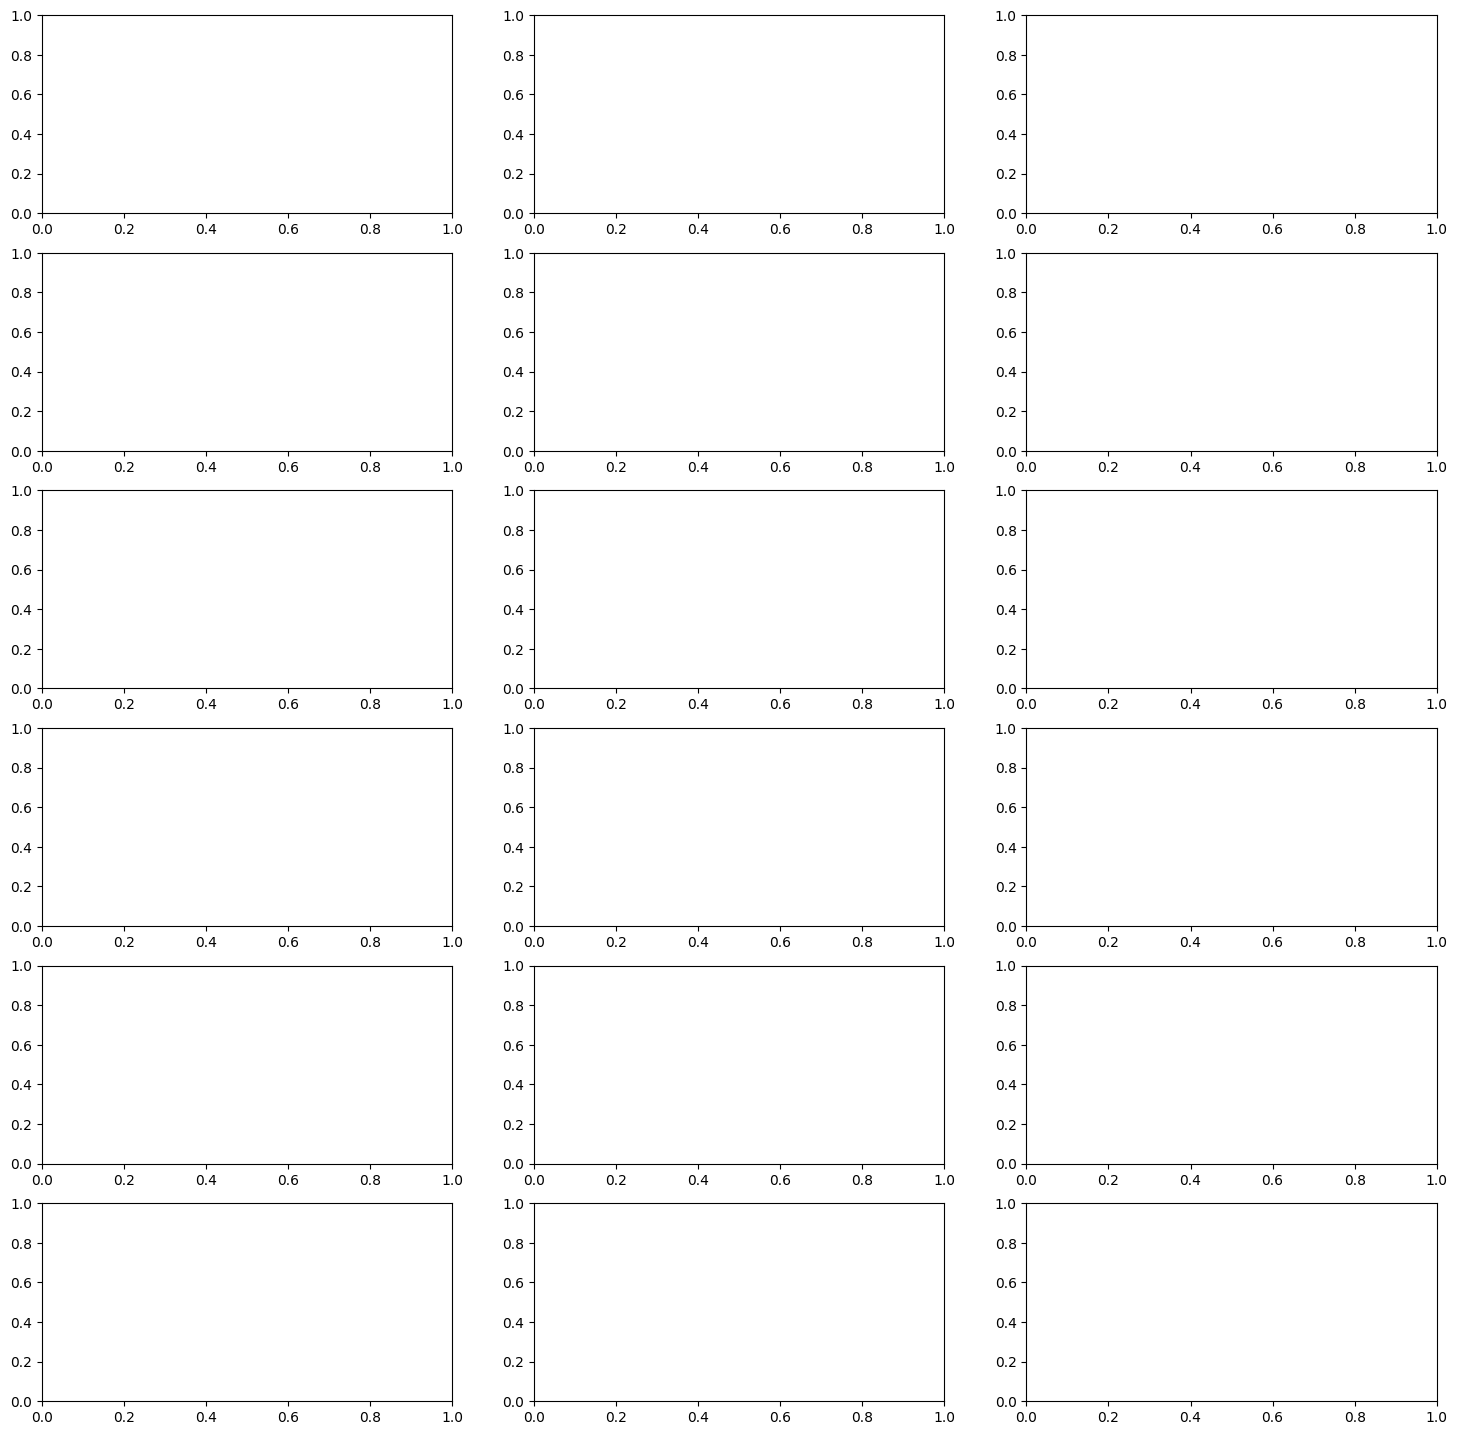

In [25]:
from sklearn.decomposition import PCA
current="LLama_Gemma_BBC"

def plot_frozen_head_alignment_pca(
    layer_types=None,
    scenario_pairs=None,
    metrics_file=f"{current}/results_metrics/approach3_frozen_head_results.json",
    save_dir="alignment_plots",
):
    """Load teacher/student checkpoints and draw PCA for each layer without retraining."""
    if layer_types is None:
        layer_types = ["attn", "mlp", "hidden"]
    if scenario_pairs is None:
        scenario_pairs = [
            {"teacher": MODEL_A, "student": MODEL_B},
            {"teacher": MODEL_B, "student": MODEL_A}
        ]
    if not os.path.exists(metrics_file):
        print(f"Impossibile trovare il file metriche: {metrics_file}")
        return

    with open(metrics_file, "r") as fh:
        metrics_data = json.load(fh)
    metrics_lookup = {
        (entry["layer_type"], entry["teacher_model"], entry["student_model"]): entry
        for entry in metrics_data
        if entry.get("training_results")
    }

    def _build_splits(model_name, seed_offset):
        stats = get_stats(model_name, DATASET_NAME)
        balanced_idx, balanced_lbl = get_undersampled_indices_per_model(stats, SEED)
        rng = np.random.RandomState(SEED + seed_offset)
        perm = rng.permutation(len(balanced_idx))
        split = int(0.7 * len(balanced_idx))
        return {
            "balanced_idx": balanced_idx,
            "balanced_labels": balanced_lbl,
            "train_idx": perm[:split],
            "test_idx": perm[split:],
        }

    splits = {
        MODEL_A: _build_splits(MODEL_A, 0),
        MODEL_B: _build_splits(MODEL_B, 1)
    }

    def _load_scaled_sets(model_name, layer_type):
        group = splits[model_name]
        X_tr, X_te, y_tr, y_te = load_and_split_layers(
            model_name,
            DATASET_NAME,
            LAYER_CONFIG[model_name][layer_type],
            layer_type,
            group["balanced_idx"],
            group["balanced_labels"],
            group["train_idx"],
            group["test_idx"],
        )
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr).astype(np.float32)
        X_te_scaled = scaler.transform(X_te).astype(np.float32)
        return X_tr_scaled, X_te_scaled, y_tr, y_te

    def _encode(encoder, array):
        encoder.eval()
        with torch.no_grad():
            tensor = torch.tensor(array, dtype=torch.float32, device=DEVICE)
            return encoder(tensor).cpu().numpy()

    num_rows = len(layer_types) * len(scenario_pairs)
    fig, axes = plt.subplots(num_rows, 3, figsize=(18, max(5, num_rows * 3)))
    axes = np.array(axes, dtype=object).reshape(num_rows, 3)

    label_names = {0: "non-hallucinated", 1: "hallucinated"}
    label_colors = {0: "#1f77b4", 1: "#d62728"}
    overlay_colors = {"teacher": "#1f77b4", "student": "#ff7f0e"}

    row_idx = 0
    for layer_type in layer_types:
        for scenario in scenario_pairs:
            key = (layer_type, scenario["teacher"], scenario["student"])
            entry = metrics_lookup.get(key)
            axes_row = axes[row_idx]
            if entry is None:
                print(f"Salto {scenario['teacher']}->{scenario['student']} ({layer_type}): mancano metriche salvate")
                for ax in axes_row:
                    ax.set_axis_off()
                row_idx += 1
                continue

            try:
                _, teacher_test, _, teacher_labels = _load_scaled_sets(scenario["teacher"], layer_type)
                _, student_test, _, student_labels = _load_scaled_sets(scenario["student"], layer_type)
            except Exception as exc:
                print(f"Errore nel caricare i layer per {scenario['teacher']}->{scenario['student']} ({layer_type}): {exc}")
                for ax in axes_row:
                    ax.set_axis_off()
                row_idx += 1
                continue

            encoder_conf = entry.get("encoder_config", ENCODER_CONFIG)
            teacher_checkpoint = torch.load(current+"/"+entry["training_results"]["teacher_encoder"]["model_saved_path"], map_location=DEVICE)
            teacher_encoder = Encoder(
                entry["training_results"]["teacher_encoder"]["input_dim"],
                encoder_conf['latent_dim'],
                encoder_conf['hidden_dim'],
                encoder_conf['dropout'],
            ).to(DEVICE)
            teacher_encoder.load_state_dict(teacher_checkpoint['model_state_dict'])

            student_checkpoint = torch.load(current+"/"+entry["training_results"]["student_encoder"]["model_saved_path"], map_location=DEVICE)
            student_encoder = Encoder(
                entry["training_results"]["student_encoder"]["input_dim"],
                encoder_conf['latent_dim'],
                encoder_conf['hidden_dim'],
                encoder_conf['dropout'],
            ).to(DEVICE)
            student_encoder.load_state_dict(student_checkpoint['model_state_dict'])

            teacher_latents = _encode(teacher_encoder, teacher_test)
            student_latents = _encode(student_encoder, student_test)

            pca = PCA(n_components=2, random_state=SEED)
            combined = np.vstack([teacher_latents, student_latents])
            pca.fit(combined)
            teacher_proj = pca.transform(teacher_latents)
            student_proj = pca.transform(student_latents)

            ax_teacher, ax_student, ax_overlap = axes_row

            for label in np.unique(teacher_labels):
                mask = teacher_labels == label
                ax_teacher.scatter(
                    teacher_proj[mask, 0],
                    teacher_proj[mask, 1],
                    s=20,
                    alpha=0.7,
                    color=label_colors.get(label, "#1f77b4"),
                    label=label_names.get(label, str(label))
                )
            ax_teacher.set_title(f"{layer_type.upper()} • {scenario['teacher']} (teacher)")
            ax_teacher.set_xlabel("PC 1")
            ax_teacher.set_ylabel("PC 2")
            ax_teacher.grid(True, alpha=0.3)
            ax_teacher.legend(loc="best", fontsize="small")

            for label in np.unique(student_labels):
                mask = student_labels == label
                ax_student.scatter(
                    student_proj[mask, 0],
                    student_proj[mask, 1],
                    s=20,
                    alpha=0.7,
                    color=label_colors.get(label, "#1f77b4"),
                    label=label_names.get(label, str(label))
                )
            ax_student.set_title(f"{layer_type.upper()} • {scenario['student']} (student)")
            ax_student.set_xlabel("PC 1")
            ax_student.set_ylabel("PC 2")
            ax_student.grid(True, alpha=0.3)
            ax_student.legend(loc="best", fontsize="small")

            ax_overlap.scatter(
                teacher_proj[:, 0],
                teacher_proj[:, 1],
                s=10,
                alpha=0.6,
                color=overlay_colors['teacher'],
                label=scenario['teacher']
            )
            ax_overlap.scatter(
                student_proj[:, 0],
                student_proj[:, 1],
                s=10,
                alpha=0.6,
                color=overlay_colors['student'],
                label=scenario['student']
            )
            ax_overlap.set_title(f"{layer_type.upper()} • Overlap {scenario['teacher']} / {scenario['student']}")
            ax_overlap.set_xlabel("PC 1")
            ax_overlap.set_ylabel("PC 2")
            ax_overlap.grid(True, alpha=0.3)
            ax_overlap.legend(loc="best", fontsize="small")

            row_idx += 1

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    os.makedirs(save_dir, exist_ok=True)
    filename = os.path.join(save_dir, f"frozen_head_alignment_pca_{MODEL_A}_{MODEL_B}_{DATASET_NAME}.pdf")
    fig.savefig(filename, dpi=200, bbox_inches="tight", format="pdf")
    plt.close(fig)
    print(f"Grafico PCA salvato in: {filename}")

plot_frozen_head_alignment_pca()